In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip uninstall pandas
!pip install pandas==1.3.5

Found existing installation: pandas 1.5.3
Uninstalling pandas-1.5.3:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/pandas-1.5.3.dist-info/*
    /usr/local/lib/python3.10/dist-packages/pandas/*
Proceed (Y/n)? n
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 92.8 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py

In [ ]:
# %cd /content
# !pip install pyyaml
# !git clone https://github.com/yaml/pyyaml.git
# !python3 setup.py --help
# %cd /content/pyyaml
# !python3 setup.py install

In [2]:
import os
import numpy as np
import pandas as pd
print(pd.__version__)
from scipy import signal

import cv2
import matplotlib.pyplot as plt
from IPython.display import Javascript
from PIL import Image
import pickle
import shutil

import torch
import torchaudio

import torchaudio.functional as F
import torchvision.transforms as Tn
import torchaudio.transforms as T

import torch.nn as nn

import torch.optim as optim
import h5py
import torch.utils.data as data
# from transforms import *
from collections import OrderedDict
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)
from torch.utils.data import Dataset, DataLoader

import librosa
!pip install tqdm
from tqdm import tqdm

1.5.3


#  1. knowing data

## 1.1 S04 data frame

In [ ]:
emg_annotations = pd.read_pickle("/content/drive/MyDrive/project/annotation/ActionNet Annotations/S04_1.pkl")
print('data shape :',emg_annotations.shape)
emg_annotations.head()


data shape : (60, 7)


,description,start,stop,myo_left_timestamps,myo_left_readings,myo_right_timestamps,myo_right_readings
0,calibration,1.655239e+09,1.655240e+09,[],[],[],[]
1,Get/replace items from refrigerator/cabinets/d...,1.655240e+09,1.655240e+09,"[1655239974.420555, 1655239974.432055, 1655239...","[[8, 7, 2, 2, 6, 5, 14, 2], [-4, 23, 19, 6, 16...","[1655239974.4195595, 1655239974.427058, 165523...","[[-2, -3, 2, 3, -8, -1, 1, -2], [3, 7, 8, -1, ..."
2,Peel a cucumber,1.655240e+09,1.655240e+09,"[1655240064.7444172, 1655240064.748419, 165524...","[[78, 57, 43, 7, 18, 18, 4, 16], [3, 0, 48, 6,...","[1655240064.7504191, 1655240064.76542, 1655240...","[[-18, 14, 26, -3, -15, -12, -26, 4], [-20, -2..."
3,Peel a cucumber,1.655240e+09,1.655240e+09,"[1655240130.5200577, 1655240130.531557, 165524...","[[-30, 20, 18, 1, 12, 23, 21, -10], [23, -15, ...","[1655240130.5190585, 1655240130.526558, 165524...","[[1, -21, 22, 14, 13, -24, -1, -12], [-58, -83..."
4,Peel a cucumber,1.655240e+09,1.655240e+09,"[1655240178.033217, 1655240178.037216, 1655240...","[[4, -19, -26, -63, -31, -36, -3, -1], [-30, -...","[1655240178.0472164, 1655240178.062216, 165524...","[[-4, 57, 49, 32, 34, 7, 7, 7], [-13, -80, -29..."


## 1.2 2.Visulaising EMG signal

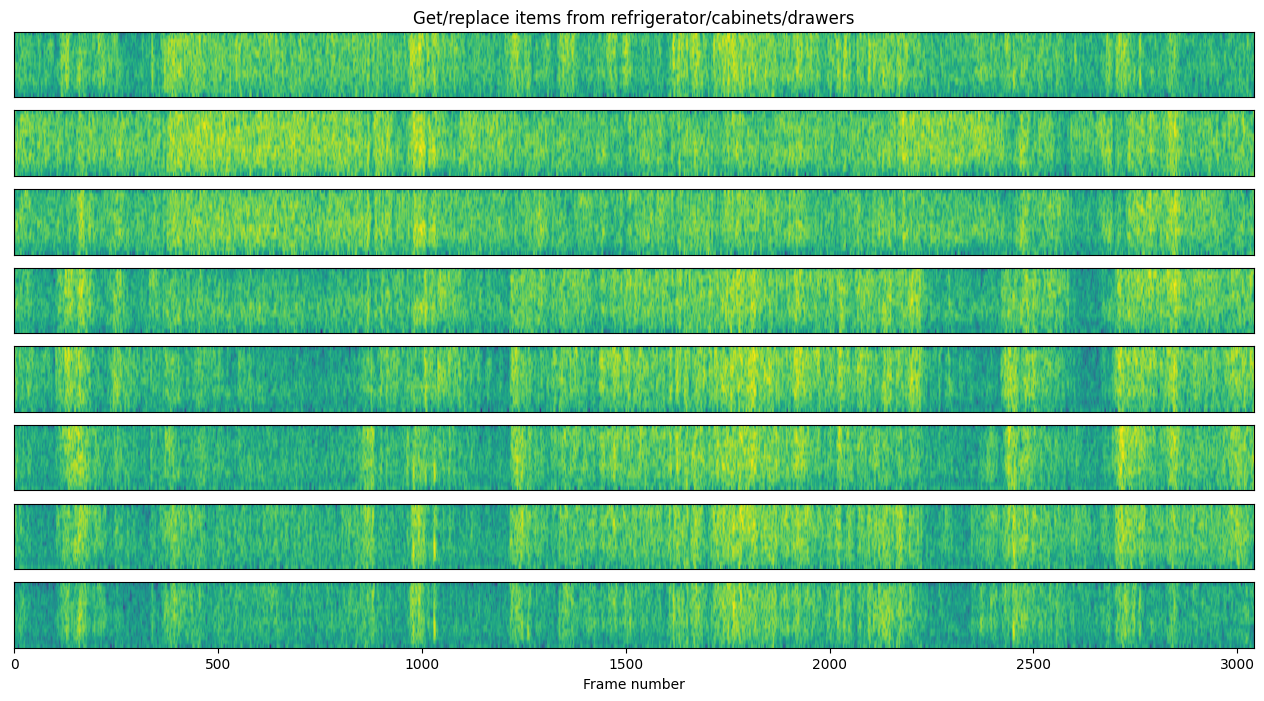

In [ ]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(len(specgram), 1, figsize=(16, 8))

    axs[0].set_title(title or "Spectrogram (db)")

    for i, spec in enumerate(specgram):
        im = axs[i].imshow(librosa.power_to_db(specgram[i]), origin="lower", aspect="auto")
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)

    axs[i].set_xlabel("Frame number")
    axs[i].get_xaxis().set_visible(True)
    plt.show(block=False)

# Sampling frequency is 160 Hz
# With 32 samples the frequency resolution after FFT is 160 / 32

n_fft = 32
win_length = None
hop_length = 4

spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    normalized=True
)


def compute_spectrogram(signal, title):
    freq_signal = [spectrogram(signal[:, i]) for i in range(8)]
    plot_spectrogram(freq_signal, title=title)

sample_no = 1
sig = torch.from_numpy(emg_annotations.iloc[sample_no].myo_left_readings).float()
title = emg_annotations.iloc[sample_no].description
##
compute_spectrogram(sig, title)

signal shape:  torch.Size([12167, 8])


<Axes: ylabel='Frequency'>

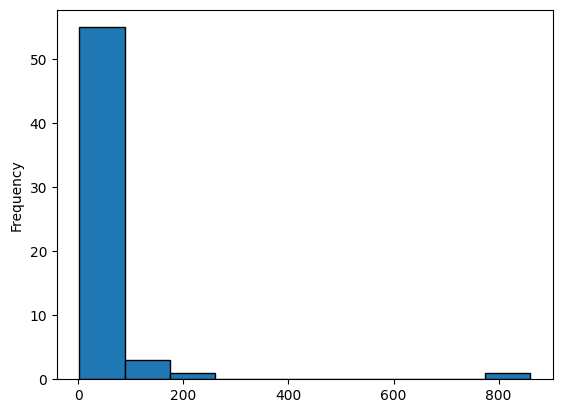

In [ ]:
print('signal shape: ',sig.shape)
(emg_annotations['stop']-emg_annotations['start']).plot(kind='hist', edgecolor='black')




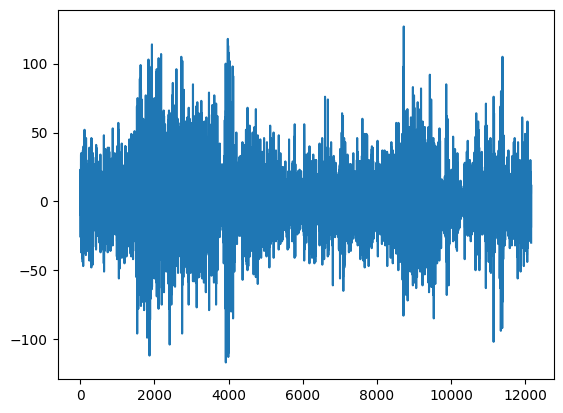

In [ ]:
x =emg_annotations['myo_left_readings'][1][:,1]
f = signal.resample(x, 100)
plt.plot(x)
plt.show()

# 1.3. Preparing test train split

In [ ]:
%cd /content/drive/MyDrive/project/mldl23-ego/action
from preprocess import prep

/content/drive/MyDrive/project/mldl23-ego/action


In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
df = prep()
print('df.shape :',df.shape)
df.columns = [col.replace(' ', '') for col in df.columns]
df = df.sort_values(['person','start'])
df.head(3)


<IPython.core.display.Javascript object>

filepath: /content/drive/MyDrive/project/annotation/ActionNet Annotations/S02_3.pkl
filepath: /content/drive/MyDrive/project/annotation/ActionNet Annotations/S01_1.pkl
filepath: /content/drive/MyDrive/project/annotation/ActionNet Annotations/S03_1.pkl
filepath: /content/drive/MyDrive/project/annotation/ActionNet Annotations/S02_4.pkl
filepath: /content/drive/MyDrive/project/annotation/ActionNet Annotations/S00_2.pkl
filepath: /content/drive/MyDrive/project/annotation/ActionNet Annotations/S02_2.pkl
filepath: /content/drive/MyDrive/project/annotation/ActionNet Annotations/S05_2.pkl
filepath: /content/drive/MyDrive/project/annotation/ActionNet Annotations/S04_1.pkl
filepath: /content/drive/MyDrive/project/annotation/ActionNet Annotations/S03_2.pkl
filepath: /content/drive/MyDrive/project/annotation/ActionNet Annotations/S06_1.pkl
filepath: /content/drive/MyDrive/project/annotation/ActionNet Annotations/S06_2.pkl
filepath: /content/drive/MyDrive/project/annotation/ActionNet Annotations/S0

,person,start,stop,label,myo_left_timestamps,myo_left_readings,myo_right_timestamps,myo_right_readings
63,S00_2,1.654640e+09,1.654640e+09,Get items from refrigerator/cabinets/drawers,"[1654640077.70674, 1654640077.710727, 16546400...","[[0.022771080516168513, 0.05045883346939615, 0...","[1654640077.704248, 1654640077.707736, 1654640...","[[0.01809502672066694, 0.1779944047098277, 0.1..."
64,S00_2,1.654640e+09,1.654640e+09,Peel a cucumber,"[1654640179.3295465, 1654640179.337021, 165464...","[[0.15536955404507538, 0.06753192282970231, 0....","[1654640179.3345332, 1654640179.342008, 165464...","[[0.01588411898837966, 0.07582561130044686, 0...."
65,S00_2,1.654640e+09,1.654640e+09,Peel a cucumber,"[1654640253.8020048, 1654640253.80599, 1654640...","[[0.18418473476046424, 0.18353598729308052, 0....","[1654640253.803004, 1654640253.8069875, 165464...","[[0.7132699694003991, 0.5849981056351677, 0.57..."


In [ ]:
df['index']= 0
init = 1
person = 'S00_2'
for index, row in df.iterrows():
  if row ['person'] == person:
     df.at[index,'index'] = init
     init +=1
  else :
    init = 1
    person = row['person']
    df.at[index,'index'] = init
    init +=1

print(df['person'].unique())

df.head(2)

['S00_2' 'S01_1' 'S02_2' 'S02_3' 'S02_4' 'S03_1' 'S03_2' 'S04_1' 'S05_2'
 'S06_1' 'S06_2' 'S07_1' 'S08_1' 'S09_2']


,person,start,stop,label,myo_left_timestamps,myo_left_readings,myo_right_timestamps,myo_right_readings,index
63,S00_2,1.654640e+09,1.654640e+09,Get items from refrigerator/cabinets/drawers,"[1654640077.70674, 1654640077.710727, 16546400...","[[0.022771080516168513, 0.05045883346939615, 0...","[1654640077.704248, 1654640077.707736, 1654640...","[[0.01809502672066694, 0.1779944047098277, 0.1...",1
64,S00_2,1.654640e+09,1.654640e+09,Peel a cucumber,"[1654640179.3295465, 1654640179.337021, 165464...","[[0.15536955404507538, 0.06753192282970231, 0....","[1654640179.3345332, 1654640179.342008, 165464...","[[0.01588411898837966, 0.07582561130044686, 0....",2


In [ ]:
my_dir = os.listdir('/content/drive/MyDrive/project/annotation/ActionNet Annotations')
person_start={}
for item in my_dir:
  B =  pd.read_pickle('/content/drive/MyDrive/project/annotation/ActionNet Annotations/'+item)
  name = item.split('.pkl')[0]
  B2 =B[B['description']=='calibration']['start']
  B2= np.array(B2)
  if not B2:
    B2 =np.array(B['start'][0])
  person_start[name]= B2.item()

<ipython-input-19-415770c88c5a>:8: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not B2:
<ipython-input-19-415770c88c5a>:8: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not B2:


In [ ]:
# availble labels
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
print('Availale labels for data frame are as follow: ')
df['label'].value_counts()

<IPython.core.display.Javascript object>

Availale labels for data frame are as follow: 


Clear cutting board                                                                           84
Get/replace items from refrigerator/cabinets/drawers                                          49
Pour water from a pitcher into a glass                                                        46
Slice a potato                                                                                29
Spread almond butter on a bread slice                                                         29
Peel a cucumber                                                                               29
Clean a pan with a towel                                                                      28
Clean a pan with a sponge                                                                     28
Clean a plate with a sponge                                                                   28
Clean a plate with a towel                                                                    27
Spread jelly on a bread slice 

In [7]:
test_df = pd.read_pickle('/content/drive/MyDrive/project/mldl23-ego/action-net/ActionNet_test.pkl')
train_df =  pd.read_pickle('/content/drive/MyDrive/project/mldl23-ego/action-net/ActionNet_train.pkl')
train_df = train_df.sort_values(['file',"index"])
test_df    =test_df.sort_values(['file',"index"])
print('test_df.shape: ',test_df.shape)
print('train_df.shape: ',train_df.shape)
train_df.reset_index(drop=True,  inplace=True)
test_df.reset_index(drop=True,  inplace=True)
print(set(train_df['labels']))
train_df.head()


test_df.shape:  (59, 4)
train_df.shape:  (527, 4)
{'Get/Put', 'Clear', 'Unload', 'Peel', 'Spread', 'Load', 'Open/Close', 'Slice', 'Pour', 'Clean', 'Stack', 'Set'}


,index,file,description,labels
0,1,S00_2.pkl,Get items from refrigerator/cabinets/drawers,Get/Put
1,2,S00_2.pkl,Peel a cucumber,Peel
2,3,S00_2.pkl,Peel a cucumber,Peel
3,4,S00_2.pkl,Peel a cucumber,Peel
4,5,S00_2.pkl,Slice a cucumber,Slice


In [3]:

for i, row in train_df.iterrows():
  ans = row['file'].split('.pkl')[0]

  train_df.at[i,'file'] = ans

for index, row2 in test_df.iterrows():
  ans = row2['file'].split('.pkl')[0]
  test_df.at[index,'file'] = ans

train_df.columns = ['index','person','description', 'labels']
test_df.columns = ['index','person','description', 'labels']

test_df.head()


NameError: ignored

In [ ]:
train_df = pd.merge(train_df, df, on=['person','index'])
test_df = pd.merge(test_df, df, on=['person','index'])
train_df.drop(columns=['label'],inplace=True )
test_df .drop(columns=['label'],inplace=True )
train_df.head()

,index,person,description,labels,start,stop,myo_left_timestamps,myo_left_readings,myo_right_timestamps,myo_right_readings
0,1,S00_2,Get items from refrigerator/cabinets/drawers,Get/Put,1.654640e+09,1.654640e+09,"[1654640077.70674, 1654640077.710727, 16546400...","[[0.022771080516168513, 0.05045883346939615, 0...","[1654640077.704248, 1654640077.707736, 1654640...","[[0.01809502672066694, 0.1779944047098277, 0.1..."
1,2,S00_2,Peel a cucumber,Peel,1.654640e+09,1.654640e+09,"[1654640179.3295465, 1654640179.337021, 165464...","[[0.15536955404507538, 0.06753192282970231, 0....","[1654640179.3345332, 1654640179.342008, 165464...","[[0.01588411898837966, 0.07582561130044686, 0...."
2,3,S00_2,Peel a cucumber,Peel,1.654640e+09,1.654640e+09,"[1654640253.8020048, 1654640253.80599, 1654640...","[[0.18418473476046424, 0.18353598729308052, 0....","[1654640253.803004, 1654640253.8069875, 165464...","[[0.7132699694003991, 0.5849981056351677, 0.57..."
3,4,S00_2,Peel a cucumber,Peel,1.654640e+09,1.654640e+09,"[1654640311.8078036, 1654640311.811295, 165464...","[[0.105933613857624, 0.07106424054704022, 0.15...","[1654640311.8053136, 1654640311.816281, 165464...","[[0.26329181316869527, 0.16192204018382655, 0...."
4,5,S00_2,Slice a cucumber,Slice,1.654640e+09,1.654640e+09,"[1654640434.595504, 1654640434.5994925, 165464...","[[0.00048214841586318667, 0.00288653029832013,...","[1654640434.593511, 1654640434.597001, 1654640...","[[0.20162397204929738, 0.28108956721048617, 0...."


In [ ]:
def time_format( seconds):

  seconds= seconds % (24 * 3600)
  hour = seconds // 3600
  seconds %= 3600
  minutes = seconds // 60
  seconds %= 60
  return("%02d:%02d:%02d:%02d" % (0,hour, minutes, seconds))

def frame_rate(time,frame_rate= 29.669551601030665 ):
    frame = round(time*frame_rate)


    return(frame)
Labels =list(set(train_df['labels']))

In [ ]:
clips_dessired_length = 4
train_df2=train_df[0:1]
index_b2 = 0
for index, row in train_df.iterrows():


    this_clip_duration =row['stop'] - row['start']
    for j in range(int(this_clip_duration//clips_dessired_length)):

       start_clip =  row['start'] +clips_dessired_length*j
       end_clip =    row['start'] +clips_dessired_length*(j+1)
       train_df2.at[index_b2,'start']  = start_clip
       train_df2.at[index_b2,'stop']   = end_clip
       train_df2.at[index_b2,'description'] =  row['description']
       train_df2.at[index_b2,'labels'] =  row['labels']
       train_df2.at[index_b2,'index'] =  index_b2
       train_df2.at[index_b2,'person'] =  row['person']
       train_df2.at[index_b2,'video_id'] =  row['person']


       train_df2.at[index_b2,'uid'] = index_b2


       train_df2.at[index_b2,'verb'] =  row['labels']
       train_df2.at[index_b2,'verb_class'] = Labels.index(row['labels'])

       accepted_righ_myo_index = np.where(np.logical_and(row['myo_right_timestamps']>=start_clip, row['myo_right_timestamps']<=end_clip))
       train_df2.at[index_b2,'myo_right_timestamps'] = row['myo_right_timestamps'][accepted_righ_myo_index]
       train_df2.at[index_b2,'myo_right_readings'] = row['myo_right_readings'][accepted_righ_myo_index]

       accepted_left_myo_index = np.where(np.logical_and(row['myo_left_timestamps']>=start_clip, row['myo_left_timestamps']<=end_clip))
       train_df2.at[index_b2,'myo_left_timestamps'] = row['myo_left_timestamps'][accepted_left_myo_index]
       train_df2.at[index_b2,'myo_left_readings'] = row['myo_left_readings'][accepted_left_myo_index]
       start_clip =start_clip -person_start[row['person']]
       end_clip = end_clip -person_start[row['person']]
       train_df2.at[index_b2,'start_timestamp'] = time_format(start_clip)
       train_df2.at[index_b2,'stop_timestamp'] = time_format(end_clip)
       train_df2.at[index_b2,'start_frame'] =  frame_rate(start_clip)
       train_df2.at[index_b2,'stop_frame'] =      frame_rate(end_clip)

       index_b2+=1
       if len(row['myo_left_readings'][accepted_left_myo_index])==0:
        print('sth is wrong' ,index , '  ',index_b2)

train_df =train_df2
train_df

<ipython-input-25-a6c0d9dbcee0>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df2.at[index_b2,'video_id'] =  row['person']
<ipython-input-25-a6c0d9dbcee0>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df2.at[index_b2,'uid'] = index_b2
<ipython-input-25-a6c0d9dbcee0>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

,index,person,description,labels,start,stop,myo_left_timestamps,myo_left_readings,myo_right_timestamps,myo_right_readings,video_id,uid,verb,verb_class,start_timestamp,stop_timestamp,start_frame,stop_frame
0,0.0,S00_2,Get items from refrigerator/cabinets/drawers,Get/Put,1.654640e+09,1.654640e+09,"[1654640077.70674, 1654640077.710727, 16546400...","[[0.022771080516168513, 0.05045883346939615, 0...","[1654640077.704248, 1654640077.707736, 1654640...","[[0.01809502672066694, 0.1779944047098277, 0.1...",S00_2,0.0,Get/Put,4.0,00:00:03:09,00:00:03:13,5613.0,5732.0
1,1.0,S00_2,Get items from refrigerator/cabinets/drawers,Get/Put,1.654640e+09,1.654640e+09,"[1654640081.707859, 1654640081.715333, 1654640...","[[0.027259468576632754, 0.06563990707772194, 0...","[1654640081.706363, 1654640081.7133415, 165464...","[[0.11137511107079077, 0.6750432322978676, 0.5...",S00_2,1.0,Get/Put,4.0,00:00:03:13,00:00:03:17,5732.0,5850.0
2,2.0,S00_2,Get items from refrigerator/cabinets/drawers,Get/Put,1.654640e+09,1.654640e+09,"[1654640085.705985, 1654640085.709474, 1654640...","[[0.12288906649018527, 0.08596937302321775, 0....","[1654640085.7069826, 1654640085.710969, 165464...","[[0.17050703641877107, 0.38315699775399314, 0....",S00_2,2.0,Get/Put,4.0,00:00:03:17,00:00:03:21,5850.0,5969.0
3,3.0,S00_2,Get items from refrigerator/cabinets/drawers,Get/Put,1.654640e+09,1.654640e+09,"[1654640089.7071035, 1654640089.710592, 165464...","[[0.020078881876603585, 0.04601597846617987, 0...","[1654640089.7086, 1654640089.716078, 165464008...","[[0.3721096634950936, 0.32898540002276105, 0.3...",S00_2,3.0,Get/Put,4.0,00:00:03:21,00:00:03:25,5969.0,6088.0
4,4.0,S00_2,Get items from refrigerator/cabinets/drawers,Get/Put,1.654640e+09,1.654640e+09,"[1654640093.7087278, 1654640093.716204, 165464...","[[0.03895073949656971, 0.18340265108591364, 0....","[1654640093.705239, 1654640093.713213, 1654640...","[[0.014220130852483684, 0.12133697973356501, 0...",S00_2,4.0,Get/Put,4.0,00:00:03:25,00:00:03:29,6088.0,6206.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4160,4160.0,S09_2,"Unload dishwasher: 3 each large/small plates, ...",Unload,1.657811e+09,1.657811e+09,"[1657810840.306656, 1657810840.322156, 1657810...","[[0.36406930656272846, 0.2260076324414123, 0.3...","[1657810840.301156, 1657810840.305656, 1657810...","[[0.13849945387758994, 0.2625363330354081, 0.3...",S09_2,4160.0,Unload,6.0,00:01:01:47,00:01:01:51,109989.0,110108.0
4161,4161.0,S09_2,"Unload dishwasher: 3 each large/small plates, ...",Unload,1.657811e+09,1.657811e+09,"[1657810844.3034387, 1657810844.310939, 165781...","[[0.1308291446178764, 0.11126661391941826, 0.1...","[1657810844.3064747, 1657810844.314011, 165781...","[[0.11661427343688428, 0.2729485812785338, 0.1...",S09_2,4161.0,Unload,6.0,00:01:01:51,00:01:01:55,110108.0,110227.0
4162,4162.0,S09_2,"Unload dishwasher: 3 each large/small plates, ...",Unload,1.657811e+09,1.657811e+09,"[1657810848.300883, 1657810848.304905, 1657810...","[[0.2542545781868104, 0.24029555496831506, 0.1...","[1657810848.303882, 1657810848.308383, 1657810...","[[0.26216966843210615, 0.2116404191759753, 0.2...",S09_2,4162.0,Unload,6.0,00:01:01:55,00:01:01:59,110227.0,110345.0
4163,4163.0,S09_2,"Unload dishwasher: 3 each large/small plates, ...",Unload,1.657811e+09,1.657811e+09,"[1657810852.306332, 1657810852.313828, 1657810...","[[0.2678931897343574, 0.13295348538421942, 0.1...","[1657810852.303828, 1657810852.3108358, 165781...","[[0.16903933980789804, 0.38252514542273053, 0....",S09_2,4163.0,Unload,6.0,00:01:01:59,00:01:02:03,110345.0,110464.0


In [ ]:
index_b2 = 0
test_df2= test_df[0:1]
for index, row in test_df.iterrows():
    this_clip_duration =row['stop'] - row['start']
    for j in range(int(this_clip_duration//clips_dessired_length)):

       start_clip =  row['start'] +clips_dessired_length*j
       end_clip =    row['start'] +clips_dessired_length*(j+1)
       test_df2.at[index_b2,'start']  = start_clip
       test_df2.at[index_b2,'stop']   = end_clip
       test_df2.at[index_b2,'description'] =  row['description']
       test_df2.at[index_b2,'labels'] =  row['labels']
       test_df2.at[index_b2,'verb'] =  row['labels']
       test_df2.at[index_b2,'index'] =  index_b2
       test_df2.at[index_b2,'person'] =  row['person']
       test_df2.at[index_b2,'verb_class'] = int(Labels.index(row['labels']))

       test_df2.at[index_b2,'video_id'] =  row['person']

       test_df2.at[index_b2,'uid'] = index_b2




       accepted_righ_myo_index = np.where(np.logical_and(row['myo_right_timestamps']>=start_clip, row['myo_right_timestamps']<=end_clip))
       test_df2.at[index_b2,'myo_right_timestamps'] = row['myo_right_timestamps'][accepted_righ_myo_index]
       test_df2.at[index_b2,'myo_right_readings'] = row['myo_right_readings'][accepted_righ_myo_index]

       accepted_left_myo_index = np.where(np.logical_and(row['myo_left_timestamps']>=start_clip, row['myo_left_timestamps']<=end_clip))
       test_df2.at[index_b2,'myo_left_timestamps'] = row['myo_left_timestamps'][accepted_left_myo_index]
       test_df2.at[index_b2,'myo_left_readings'] = row['myo_left_readings'][accepted_left_myo_index]

       start_clip =start_clip -person_start[row['person']]
       end_clip = end_clip -person_start[row['person']]

       test_df2.at[index_b2,'start_timestamp'] = time_format( start_clip)
       test_df2.at[index_b2,'stop_timestamp'] = time_format(end_clip)
       test_df2.at[index_b2,'start_frame'] = frame_rate(start_clip)
       test_df2.at[index_b2,'stop_frame'] =   frame_rate(end_clip)

       index_b2+=1
       if len(row['myo_left_readings'][accepted_left_myo_index])==0:
        print('sth is wrong')
test_df =test_df2
test_df.head(-5)

<ipython-input-26-575df832f5c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df2.at[index_b2,'verb'] =  row['labels']
<ipython-input-26-575df832f5c1>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df2.at[index_b2,'verb_class'] = int(Labels.index(row['labels']))
<ipython-input-26-575df832f5c1>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

,index,person,description,labels,start,stop,myo_left_timestamps,myo_left_readings,myo_right_timestamps,myo_right_readings,verb,verb_class,video_id,uid,start_timestamp,stop_timestamp,start_frame,stop_frame
0,0.0,S00_2,Clean a plate with a towel,Clean,1.654642e+09,1.654642e+09,"[1654642217.725646, 1654642217.7331014, 165464...","[[0.49019358373177363, 0.19488855829861895, 0....","[1654642217.722619, 1654642217.7300959, 165464...","[[0.35454237508261083, 0.40997337361037195, 0....",Clean,1.0,S00_2,0.0,00:00:38:49,00:00:38:53,69106.0,69225.0
1,1.0,S00_2,Clean a plate with a towel,Clean,1.654642e+09,1.654642e+09,"[1654642221.723241, 1654642221.7267306, 165464...","[[0.5653983572327649, 0.2732221536026452, 0.63...","[1654642221.727228, 1654642221.7312126, 165464...","[[0.31882859336518593, 0.5647283709981729, 0.2...",Clean,1.0,S00_2,1.0,00:00:38:53,00:00:38:57,69225.0,69344.0
2,2.0,S00_2,"Unload dishwasher: 3 each large/small plates, ...",Unload,1.654643e+09,1.654643e+09,"[1654642980.411643, 1654642980.4156294, 165464...","[[0.0009416663822613625, 0.008312422357275785,...","[1654642980.409656, 1654642980.413141, 1654642...","[[0.023810040793053492, 0.12248217390950113, 0...",Unload,6.0,S00_2,2.0,00:00:51:31,00:00:51:35,91735.0,91853.0
3,3.0,S00_2,"Unload dishwasher: 3 each large/small plates, ...",Unload,1.654643e+09,1.654643e+09,"[1654642984.40958, 1654642984.42104, 165464298...","[[0.34637147359893766, 0.19844919794739713, 0....","[1654642984.414563, 1654642984.429511, 1654642...","[[0.10708084290762171, 0.1849517784479471, 0.1...",Unload,6.0,S00_2,3.0,00:00:51:35,00:00:51:39,91853.0,91972.0
4,4.0,S00_2,"Unload dishwasher: 3 each large/small plates, ...",Unload,1.654643e+09,1.654643e+09,"[1654642988.41396, 1654642988.421435, 16546429...","[[0.01696734745232523, 0.043856079570264425, 0...","[1654642988.4079845, 1654642988.411478, 165464...","[[0.09218196392965733, 0.20280123141362816, 0....",Unload,6.0,S00_2,4.0,00:00:51:39,00:00:51:43,91972.0,92091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,446.0,S09_2,Spread jelly on a bread slice,Spread,1.657809e+09,1.657809e+09,"[1657809332.5032005, 1657809332.514205, 165780...","[[0.17639798037482063, 0.19191503447019087, 0....","[1657809332.495196, 1657809332.5027, 165780933...","[[0.23950069252319353, 0.21703114281705047, 0....",Spread,8.0,S09_2,446.0,00:00:36:39,00:00:36:43,65253.0,65372.0
447,447.0,S09_2,Spread jelly on a bread slice,Spread,1.657809e+09,1.657809e+09,"[1657809336.492703, 1657809336.496203, 1657809...","[[0.16697006124867547, 0.15824989799883252, 0....","[1657809336.493195, 1657809336.493695, 1657809...","[[0.1670575403693803, 0.23127894741770705, 0.6...",Spread,8.0,S09_2,447.0,00:00:36:43,00:00:36:47,65372.0,65491.0
448,448.0,S09_2,Spread jelly on a bread slice,Spread,1.657809e+09,1.657809e+09,"[1657809346.0216951, 1657809346.029195, 165780...","[[0.197749469597679, 0.24842740739340524, 0.20...","[1657809346.021195, 1657809346.025195, 1657809...","[[0.15566089140760156, 0.29550120923625256, 0....",Spread,8.0,S09_2,448.0,00:00:36:52,00:00:36:56,65655.0,65773.0
449,449.0,S09_2,Spread jelly on a bread slice,Spread,1.657809e+09,1.657809e+09,"[1657809350.026699, 1657809350.038198, 1657809...","[[0.08281935749398157, 0.14156250856684388, 0....","[1657809350.023697, 1657809350.0241976, 165780...","[[0.1086599927859164, 0.15132787596616212, 0.1...",Spread,8.0,S09_2,449.0,00:00:36:56,00:00:37:00,65773.0,65892.0


In [ ]:
train_df['verb_class'] = train_df['verb_class'].astype(int)
test_df['verb_class'] = test_df['verb_class'].astype(int)
df_s04_train  =train_df[train_df['person']=="S04_1"]
df_s04_test  = test_df[test_df['person']=="S04_1"]


print('df_s04_train.shape: ',df_s04_train.shape)
print('df_s04_test.shape: ',df_s04_test.shape)

# df_s04_train.to_pickle("/content/drive/MyDrive/project/mldl23-ego/train_val/S4_train.pkl",protocol=4)
# df_s04_test.to_pickle("/content/drive/MyDrive/project/mldl23-ego/train_val/S4_test.pkl",protocol=4)

df_s04_train.shape:  (420, 18)
df_s04_test.shape:  (37, 18)


In [ ]:
tem = pd.concat([df_s04_train, df_s04_test]).sample(frac = 1,random_state=1)
df_s04_train =tem[0:int(0.8*len(tem))]
df_s04_test =tem[int(0.8*len(tem)):]
print('df_s04_train.shape: ',df_s04_train.shape)
df_s04_train.head()


df_s04_train.shape:  (365, 18)


,index,person,description,labels,start,stop,myo_left_timestamps,myo_left_readings,myo_right_timestamps,myo_right_readings,video_id,uid,verb,verb_class,start_timestamp,stop_timestamp,start_frame,stop_frame
1539,1539.0,S04_1,Slice a cucumber,Slice,1.655240e+09,1.655240e+09,"[1655240315.104999, 1655240315.108999, 1655240...","[[0.37731988057258264, 0.10067176112794013, 0....","[1655240315.104497, 1655240315.112, 1655240315...","[[0.3885813057113619, 0.37526796460081413, 0.4...",S04_1,1539.0,Slice,5,00:00:20:00,00:00:20:04,35631.0,35749.0
1618,1618.0,S04_1,Peel a potato,Peel,1.655241e+09,1.655241e+09,"[1655240724.1344895, 1655240724.14199, 1655240...","[[0.39665204294623213, 0.25069209110640306, 0....","[1655240724.13699, 1655240724.1409895, 1655240...","[[0.09615310851449338, 0.09943158054930422, 0....",S04_1,1618.0,Peel,7,00:00:26:49,00:00:26:53,47766.0,47885.0
1795,1795.0,S04_1,Get items from cabinets: 3 each large/small pl...,Get/Put,1.655242e+09,1.655242e+09,"[1655241943.148655, 1655241943.156157, 1655241...","[[0.14168184019883917, 0.13998483156896818, 0....","[1655241943.144157, 1655241943.147655, 1655241...","[[0.1859661449072568, 0.3863039742895133, 0.61...",S04_1,1795.0,Get/Put,4,00:00:47:08,00:00:47:12,83934.0,84053.0
1723,1723.0,S04_1,Open/close a jar of almond butter,Open/Close,1.655241e+09,1.655241e+09,"[1655241405.9314275, 1655241405.938928, 165524...","[[0.33097352654833984, 0.2960456577218045, 0.0...","[1655241405.9304256, 1655241405.933922, 165524...","[[0.023216046152132814, 0.04017757709286478, 0...",S04_1,1723.0,Open/Close,3,00:00:38:11,00:00:38:15,67995.0,68114.0
1696,1696.0,S04_1,Get/replace items from refrigerator/cabinets/d...,Get/Put,1.655241e+09,1.655241e+09,"[1655241193.940728, 1655241193.948228, 1655241...","[[0.4324800755774884, 0.246490129483789, 0.295...","[1655241193.9437337, 1655241193.951235, 165524...","[[0.08155168875012757, 0.16119777519197842, 0....",S04_1,1696.0,Get/Put,4,00:00:34:39,00:00:34:43,61705.0,61824.0


In [ ]:
train_df = train_df[train_df['person']!="S04_1"]
test_df  = test_df[test_df['person']!="S04_1"]
train_df = pd.concat([df_s04_train, train_df])
test_df = pd.concat([df_s04_test, test_df])
# df_s04_train.to_pickle("/content/drive/MyDrive/project/mldl23-ego/train_val/S4_train.pkl",protocol=4)
# df_s04_test.to_pickle("/content/drive/MyDrive/project/mldl23-ego/train_val/S4_test.pkl",protocol=4)

In [ ]:
df_s04_train.isna().sum()

index                   0
person                  0
description             0
labels                  0
start                   0
stop                    0
myo_left_timestamps     0
myo_left_readings       0
myo_right_timestamps    0
myo_right_readings      0
video_id                0
uid                     0
verb                    0
verb_class              0
start_timestamp         0
stop_timestamp          0
start_frame             0
stop_frame              0
dtype: int64

In [ ]:
print('df_s04_test.shape : ',df_s04_test.shape)
df_s04_test.isna().sum()

df_s04_test.shape :  (92, 18)


index                   0
person                  0
description             0
labels                  0
start                   0
stop                    0
myo_left_timestamps     0
myo_left_readings       0
myo_right_timestamps    0
myo_right_readings      0
video_id                0
uid                     0
verb                    0
verb_class              0
start_timestamp         0
stop_timestamp          0
start_frame             0
stop_frame              0
dtype: int64

<Axes: ylabel='verb'>

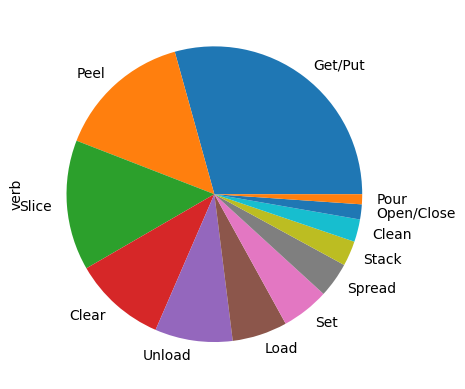

In [ ]:
df_s04_train_count =df_s04_train['verb'].value_counts()
df_s04_train_count.plot(kind='pie')

<Axes: ylabel='verb'>

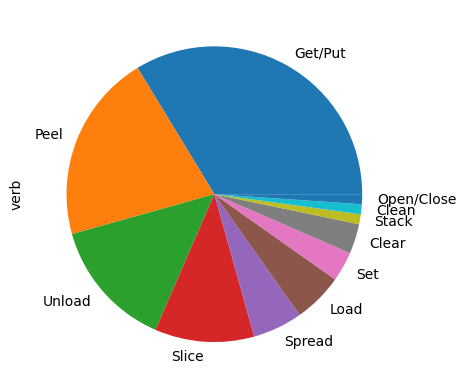

In [ ]:
df_s04_test_count =df_s04_test['verb'].value_counts()
df_s04_test_count.plot(kind='pie'
)

<Axes: ylabel='verb'>

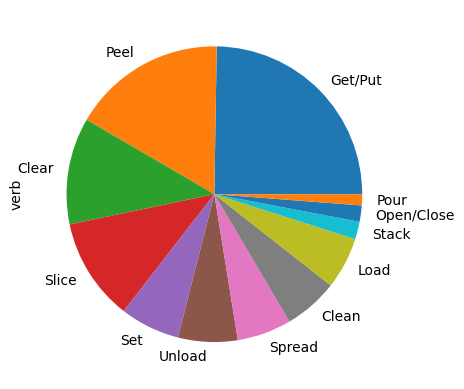

In [ ]:
train_df_count =train_df['verb'].value_counts()
train_df_count.plot(kind='pie')

<Axes: ylabel='verb'>

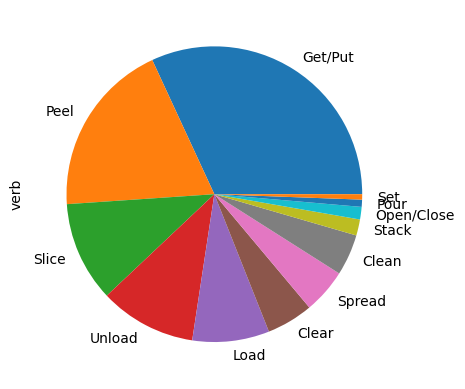

In [ ]:
test_df_count =test_df['verb'].value_counts()
test_df_count.plot(kind='pie')

# 2. task1: using Lstm to analyse signal

## 2.1 data loader for lstm task

In [ ]:
class signal_loader(Dataset):

    def __init__(self, df,label_verbs, num_sample=100, transform=None):
        self.myo_left = list(df['myo_left_readings'])
        self.myo_right =list( df['myo_right_readings'])
        # self.labels = list(df['labels'])
        self.labels_list =  list(df['verb_class'])
        self.uids = list(df['uid'])
        self.label_verbs =label_verbs
        self.transform = transform
        self.num_sample = num_sample
    def __len__(self):
        return len(self.myo_left)

    def __getitem__(self, idx):
        left = torch.from_numpy( signal.resample(self.myo_left[idx], self.num_sample) ).float()
        right = torch.from_numpy(signal.resample(self.myo_right[idx], self.num_sample)).float()
        cat_sig = torch.cat((left,right),1)
        label = torch.zeros(len(self.label_verbs))
        uid  = self.uids[idx]
        index = int(self.labels_list[idx])

        label[index] =1
        return cat_sig,label,uid


In [ ]:
label_verbs = set(train_df['verb_class'])
from sklearn.model_selection import train_test_split
# Set a seed for reproducibility
random_seed = 42
train_data = signal_loader( train_df,label_verbs)
train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True)
test_data = signal_loader( df_s04_test,label_verbs)
test_dataloader = DataLoader(test_data, batch_size=4, shuffle=True)

test_data_t = signal_loader( test_df,label_verbs)
test_dataloader_t = DataLoader(test_data_t , batch_size=4, shuffle=True)


train_data_s04 = signal_loader( df_s04_train,label_verbs)
train_dataloader_s04 = DataLoader(train_data_s04 , batch_size=4, shuffle=True)
# to check
si,act,uids = next(iter(train_dataloader ))
print('Data size when dataloader is called:   :',si.shape)
print('labels for one bacth : \n',act)
print('uids are :',np.array(uids))

Data size when dataloader is called:   : torch.Size([4, 100, 16])
labels for one bacth : 
 tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])
uids are : [2142. 1747. 1277. 3277.]


## 2.2 model

In [ ]:
class ACT_LS(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=16, hidden_size=5, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=5, hidden_size=50, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.flat =  nn.Flatten()
        self.linear = nn.Linear(5000, 12)
        self.last = torch.nn.Softmax(1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x, _ = self.lstm2(x)
        x =  self.dropout(x)
        features = self.flat(x)
        # x =  self.dropout(x)
        x = self.linear(features)
        # x = self.last(x)
        return x,features

model =  ACT_LS()
model = model.to(device)
optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()

### 2.3 traing and validation

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
n_epochs = 40
best_acc = 0
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    corrects =0
    total = 0
    for X_batch, y_batch,_ in train_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred ,_= model(X_batch)
        # print('y_batch: ',y_batch)
        loss = criterion(y_pred, y_batch)
        # print('y_pred.shape; ', y_pred.shape,'  ',y_batch.shape)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
        total +=X_batch.shape[0]
        _, preds = torch.max(y_pred,1)
        # print('preds:  ',preds  , ' real: ',real)
        _,real = torch.max(y_batch,1)

        corrects += torch.sum(preds ==real)

    train_acc =  corrects/total*100
    test_loss = 0
    corrects =0
    total = 0
    corrects_t =0
    total_t = 0
    corrects_s04 =0
    total_train_s04 = 0
    model.eval()
    with torch.no_grad():
      for X_test, y_test,_ in test_dataloader:
        X_test, y_test = X_test.to(device), y_test.to(device)


        y_pred ,_= model(X_test)
        _, preds = torch.max(y_pred,1)
        _,real = torch.max(y_test,1)
        corrects += torch.sum(preds ==real)
        total +=X_test.shape[0]

      for X_test, y_test,_ in test_dataloader_t:
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_pred,_ = model(X_test)


        _, preds = torch.max(y_pred,1)
        _,real = torch.max(y_test,1)
        corrects_t += torch.sum(preds ==real)
        total_t +=X_test.shape[0]

      for X_test, y_test,_ in train_dataloader_s04:
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_pred,_ = model(X_test)


        _, preds = torch.max(y_pred,1)
        _,real = torch.max(y_test,1)
        corrects_s04 += torch.sum(preds ==real)
        total_train_s04 +=X_test.shape[0]







    test_acc   =  corrects/total*100
    train_s04_acc = corrects_s04/ total_train_s04 *100
    test_acc_t =corrects_t/total_t*100
    if test_acc_t>best_acc:
        torch.save(model.state_dict(),'/content/model_scripted.pt')
        best_acc = test_acc_t
    print('sample check : y_pred are {} and real y are {} '.format(preds,real))
    print("Epoch {:2d}: train_loss {:.3f},train_acc  {:.1f}, test acc  {:.1f}, test acc on total data {:.1f} , acc on s04 train  {:.1f}" .format(epoch, train_loss, train_acc ,test_acc,test_acc_t,train_s04_acc))

<IPython.core.display.Javascript object>

sample check : y_pred are tensor([4], device='cuda:0') and real y are tensor([6], device='cuda:0') 
Epoch  0: train_loss 1898.320,train_acc  38.2, test acc  33.7, test acc on total data 38.4 , acc on s04 train  44.7
sample check : y_pred are tensor([4], device='cuda:0') and real y are tensor([4], device='cuda:0') 
Epoch  1: train_loss 1731.137,train_acc  43.0, test acc  29.3, test acc on total data 38.2 , acc on s04 train  38.9
sample check : y_pred are tensor([4], device='cuda:0') and real y are tensor([10], device='cuda:0') 
Epoch  2: train_loss 1661.610,train_acc  45.8, test acc  37.0, test acc on total data 43.6 , acc on s04 train  43.0
sample check : y_pred are tensor([4], device='cuda:0') and real y are tensor([4], device='cuda:0') 
Epoch  3: train_loss 1603.481,train_acc  47.4, test acc  38.0, test acc on total data 44.2 , acc on s04 train  49.6
sample check : y_pred are tensor([4], device='cuda:0') and real y are tensor([6], device='cuda:0') 
Epoch  4: train_loss 1541.594,train

In [ ]:
model =  ACT_LS()
model.load_state_dict(torch.load('/content/model_scripted.pt'))
model = model.to(device)
model.eval()

results_dict = {"features": []}
for X_batch, y_batch,uids in train_dataloader_s04 :
      uids = np.array((uids))
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)
      _,real = torch.max(y_batch,1)
      _,feat = model(X_batch)
      for i in range(len( X_batch)):
        sample = {"uid": int(uids[i]) }
        sample["features_" + 'myo']=feat[i,:].cpu().detach().numpy()
        sample['label']= real[i].cpu().detach().numpy()
        results_dict["features"].append(sample)


pickle.dump(results_dict, open('/content/drive/MyDrive/project/mldl23-ego/saved_features/myo_train.pkl','wb'))


results_dict = {"features": []}
for X_batch, y_batch,uids in test_dataloader :
      uids = np.array((uids))
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)
      _,feat = model(X_batch)
      _,real = torch.max(y_batch,1)
      for i in range(len( X_batch)):
        sample = {"uid": int(uids[i]) }
        sample["features_" + 'myo']=feat[i,:].cpu().detach().numpy()
        sample['label']= real[i].cpu().detach().numpy()
        results_dict["features"].append(sample)

pickle.dump(results_dict, open('/content/drive/MyDrive/project/mldl23-ego/saved_features/myo_test.pkl','wb'))



---

---



---
# 3. task2: spectrogram of the EMG data



## 3.1 preparing data

In [ ]:
class spect_loader(Dataset):

    def __init__(self, df, labels_list,output_size = 256,num_sample=10000, transform=None):

        self.myo_left = list(df['myo_left_readings'])
        self.myo_right =list( df['myo_right_readings'])
        self.labels = list(df['verb_class'])
        self.labels_list =  labels_list

        self.transform = transform
        self.num_sample = num_sample
        self.output_size = output_size
        self.transform = Tn.Resize((output_size,output_size))

    def __len__(self):
        return len(self.myo_left)

    def __getitem__(self, idx):
        left = ( signal.resample(self.myo_left[idx], self.num_sample) )
        right = (signal.resample(self.myo_right[idx], self.num_sample))

        cat_sig = np.concatenate((left, right), axis=1)
        cat_sig = np.swapaxes(cat_sig,  0, 1)
        single_Chanel_sig = librosa.to_mono(cat_sig)
        spec =  torch.from_numpy(self._log_specgram(single_Chanel_sig)).float()
        spec = torch.unsqueeze(spec, 0)
        spec  = self.transform(spec)

        label =  torch.zeros(len(self.labels_list))

        index =  self.labels_list.index(self.labels[idx])
        label[index] =1
        return spec,label
    def _log_specgram( self,audio, window_size=10,
                  step_size=5, eps=1e-6):

      nperseg = int(round(window_size * 10000/ 1e3))
      noverlap = int(round(step_size * 10000 / 1e3))


      spec = librosa.stft(audio, n_fft=511,
                            window='hann',
                            hop_length=noverlap,
                            win_length=nperseg,
                            pad_mode='constant')

      spec = np.log(np.real(spec * np.conj(spec)) + eps)

      return spec
random_seed = 42
label_verbs = list(set(train_df['verb_class']))
train_data = spect_loader( train_df, labels_list=label_verbs)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)

train_data_s04 = spect_loader( df_s04_train, labels_list=label_verbs)
train_dataloader_s04 = DataLoader(train_data_s04, batch_size=32, shuffle=True)

test_data = spect_loader( df_s04_test, labels_list=label_verbs)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)


test_data_total = spect_loader( test_df, labels_list=label_verbs)
test_dataloader_total = DataLoader(test_data_total, batch_size=64, shuffle=True)


In [ ]:
img,sig =next(iter(train_dataloader))
print('sig: ',sig)

img.shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


sig:  tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        

torch.Size([32, 1, 256, 256])

## 3.2 model

In [ ]:
# %cd /content/drive/MyDrive/project/mldl23-ego/model_for_signal_spec
# !git clone https://github.com/ekazakos/temporal-binding-network.git
%cd /content/drive/MyDrive/project/mldl23-ego/model_for_signal_spec/temporal-binding-network
import tf_model_zoo

/content/drive/MyDrive/project/mldl23-ego/model_for_signal_spec/temporal-binding-network


In [ ]:
class signal_model(nn.Module):
    def __init__(self, num_class,
                 base_model='BNInception', new_length=None,
                 consensus_type='avg', before_softmax=True,
                 dropout=0.6,
                 crop_num=1, midfusion='concat'):
        super(signal_model, self).__init__()
        self.num_class = num_class
        # self.base_model   = base_model
        self.dropout = dropout
        self.new_length= new_length
        self.input_size = 224
        self.input_std = [1]
        self.feature_dim = 1024
        self.base_model = getattr(tf_model_zoo, base_model)()
        self.base_model = self._construct_spec_model(self.base_model)
        self.base_model.last_layer_name = 'fc'
        self.last_layer  =nn.Linear(1000, 12)
    def _remove_last_layer(self):

        for m in self.modality:
            delattr(self.base_model[m], self.base_model[m].last_layer_name)
            for tup in self.base_model[m]._op_list:
                if tup[0] == self.base_model[m].last_layer_name:
                    self.base_model[m]._op_list.remove(tup)
    def forward(self, input):
        channel =16
        sample_len = channel * self.new_length
        base_out = self.base_model(input)
        output = base_out
        output = self.last_layer(output)

        return output


    def _construct_spec_model(self, base_model):
        # modify the convolution layers
        # Torch models are usually defined in a hierarchical way.
        # nn.modules.children() return all sub modules in a DFS manner
        modules = list(self.base_model.modules())
        first_conv_idx = list(filter(lambda x: isinstance(modules[x], nn.Conv2d), list(range(len(modules)))))[0]
        conv_layer = modules[first_conv_idx]
        container = modules[first_conv_idx - 1]

        # modify parameters, assume the first blob contains the convolution kernels
        params = [x.clone() for x in conv_layer.parameters()]
        new_kernels = params[0].detach().mean(dim=1, keepdim=True).contiguous()

        new_conv = nn.Conv2d(self.new_length, conv_layer.out_channels,
                             conv_layer.kernel_size, conv_layer.stride, conv_layer.padding,
                             bias=True if len(params) == 2 else False)

        new_conv.weight.data = new_kernels
        if len(params) == 2:
            new_conv.bias.data = params[1].detach() # add bias if neccessary
        layer_name = list(container.state_dict().keys())[0][:-7] # remove .weight suffix to get the layer name

        # replace the first convolution layer
        setattr(container, layer_name, new_conv)

        # replace the avg pooling at the end, so that it matches the spectrogram dimensionality (256x256)
        pool_layer = getattr(self.base_model, 'global_pool')
        new_avg_pooling = nn.AvgPool2d(8, stride=pool_layer.stride, padding=pool_layer.padding)
        setattr(self.base_model, 'global_pool', new_avg_pooling)

        return base_model

In [ ]:
model = signal_model(num_class =12,new_length=1)
print(model)
model = model.to(device)
# optimizer = optim.Adam(model.parameters())
optimizer = torch.optim.SGD(model.parameters(),lr=0.0001)

criterion = nn.CrossEntropyLoss()

signal_model(
  (base_model): BNInception(
    (conv1_7x7_s2): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (conv1_7x7_s2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1_relu_7x7): ReLU(inplace=True)
    (pool1_3x3_s2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv2_3x3_reduce): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (conv2_3x3_reduce_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2_relu_3x3_reduce): ReLU(inplace=True)
    (conv2_3x3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_3x3_bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2_relu_3x3): ReLU(inplace=True)
    (pool2_3x3_s2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (inception_3a_1x1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
    (incep

In [ ]:
n_epochs = 30
check= 0
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    corrects =0
    total = 0
    for X_batch, y_batch in tqdm(train_dataloader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
        total +=X_batch.shape[0]
        _, preds = torch.max(y_pred,1)
        _,real = torch.max(y_batch,1)
        corrects += torch.sum(preds ==real)

    train_acc =  corrects/total*100
    test_loss = 0
    corrects =0
    total = 0
    model.eval()
    with torch.no_grad():
      for X_test, y_test in test_dataloader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_pred = model(X_test)

        loss_t = criterion(y_pred, y_test)
        y_pred = model(X_test)
        _, preds = torch.max(y_pred,1)

        _,real = torch.max(y_test,1)
        corrects += torch.sum(preds ==real)

        total +=X_test.shape[0]
        if check==0:
          print('y sample: ')
          print('pred: ',preds)
          print('real: ',real)
          check =1

      corrects_t =0
      total_t = 0
      for X_test, y_test in test_dataloader_total:
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_pred = model(X_test)

        loss_t = criterion(y_pred, y_test)
        y_pred = model(X_test)
        _, preds = torch.max(y_pred,1)

        _,real = torch.max(y_test,1)
        corrects_t += torch.sum(preds ==real)

        total_t +=X_test.shape[0]

      corrects_t_s04 =0
      total_t_s04 = 0
    for X_test, y_test in train_dataloader_s04:
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_pred = model(X_test)

        loss_t = criterion(y_pred, y_test)
        y_pred = model(X_test)
        _, preds = torch.max(y_pred,1)

        _,real = torch.max(y_test,1)
        corrects_t_s04 += torch.sum(preds ==real)

        total_t_s04 += X_test.shape[0]




    test_acc   =  corrects/total*100
    tets_acc_s04 =corrects_t_s04/total_t_s04*100
    tets_acc_t = corrects_t/ total_t*100
    print("Epoch %d: train_loss %.4f, train_acc  %.4f, test acc for s04 %.4f,ac on trainset of S04 %.4f, test acc for all participant: %.4f " % (epoch, train_loss,train_acc ,test_acc,tets_acc_s04,tets_acc_t))

100%|██████████| 129/129 [00:59<00:00,  2.18it/s]


y sample: 
pred:  tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 2, 4,
        2, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 4], device='cuda:0')
real:  tensor([ 5,  7, 11,  7,  5,  1,  4,  8,  5,  7,  6,  6,  5,  6,  7,  4,  4,  0,
         4,  4, 10,  7,  4,  4,  6,  4,  4, 10,  4,  7,  4,  7,  4,  5,  6, 11,
        10,  0,  6,  6,  5,  8,  4,  5,  7,  4, 11,  4,  7,  4,  5,  6,  3,  4,
         6,  7, 10,  7,  4,  9,  6,  4,  4,  5], device='cuda:0')
Epoch 0: train_loss 285.6882, train_acc  26.8856, test acc for s04 23.9130,ac on trainset of S04 21.9178, test acc for all participant: 19.1781 


100%|██████████| 129/129 [00:54<00:00,  2.38it/s]


Epoch 1: train_loss 259.2101, train_acc  32.0925, test acc for s04 35.8696,ac on trainset of S04 34.5205, test acc for all participant: 34.4423 


100%|██████████| 129/129 [00:54<00:00,  2.38it/s]


Epoch 2: train_loss 248.4525, train_acc  33.7226, test acc for s04 26.0870,ac on trainset of S04 22.7397, test acc for all participant: 24.0704 


100%|██████████| 129/129 [00:54<00:00,  2.35it/s]


Epoch 3: train_loss 243.8690, train_acc  33.7713, test acc for s04 36.9565,ac on trainset of S04 35.0685, test acc for all participant: 34.8337 


100%|██████████| 129/129 [00:55<00:00,  2.34it/s]


Epoch 4: train_loss 242.2217, train_acc  34.9148, test acc for s04 3.2609,ac on trainset of S04 5.2055, test acc for all participant: 0.5871 


100%|██████████| 129/129 [00:54<00:00,  2.38it/s]


Epoch 5: train_loss 259.9378, train_acc  32.6034, test acc for s04 28.2609,ac on trainset of S04 38.9041, test acc for all participant: 33.4638 


100%|██████████| 129/129 [00:54<00:00,  2.37it/s]


Epoch 6: train_loss 245.1228, train_acc  34.6959, test acc for s04 34.7826,ac on trainset of S04 35.6164, test acc for all participant: 37.9648 


100%|██████████| 129/129 [00:54<00:00,  2.37it/s]


Epoch 7: train_loss 240.5960, train_acc  35.3041, test acc for s04 30.4348,ac on trainset of S04 42.1918, test acc for all participant: 34.4423 


100%|██████████| 129/129 [00:54<00:00,  2.35it/s]


Epoch 8: train_loss 236.8919, train_acc  36.5207, test acc for s04 30.4348,ac on trainset of S04 43.2877, test acc for all participant: 34.8337 


100%|██████████| 129/129 [00:53<00:00,  2.39it/s]


Epoch 9: train_loss 234.8231, train_acc  36.6667, test acc for s04 30.4348,ac on trainset of S04 35.8904, test acc for all participant: 34.6380 


100%|██████████| 129/129 [00:54<00:00,  2.39it/s]


Epoch 10: train_loss 233.1091, train_acc  37.5669, test acc for s04 39.1304,ac on trainset of S04 39.1781, test acc for all participant: 36.7906 


100%|██████████| 129/129 [00:54<00:00,  2.39it/s]


Epoch 11: train_loss 230.1380, train_acc  37.5426, test acc for s04 28.2609,ac on trainset of S04 38.9041, test acc for all participant: 34.8337 


100%|██████████| 129/129 [00:54<00:00,  2.36it/s]


Epoch 12: train_loss 228.6958, train_acc  38.1752, test acc for s04 33.6957,ac on trainset of S04 41.9178, test acc for all participant: 35.6164 


100%|██████████| 129/129 [00:54<00:00,  2.38it/s]


Epoch 13: train_loss 227.3148, train_acc  38.1022, test acc for s04 33.6957,ac on trainset of S04 43.0137, test acc for all participant: 36.0078 


100%|██████████| 129/129 [00:53<00:00,  2.40it/s]


Epoch 14: train_loss 226.8473, train_acc  39.2701, test acc for s04 33.6957,ac on trainset of S04 40.8219, test acc for all participant: 35.6164 


100%|██████████| 129/129 [00:53<00:00,  2.43it/s]


Epoch 15: train_loss 224.5354, train_acc  39.3187, test acc for s04 36.9565,ac on trainset of S04 43.2877, test acc for all participant: 36.5949 


100%|██████████| 129/129 [00:54<00:00,  2.38it/s]


Epoch 16: train_loss 222.3442, train_acc  39.6594, test acc for s04 38.0435,ac on trainset of S04 32.6027, test acc for all participant: 34.4423 


100%|██████████| 129/129 [00:54<00:00,  2.38it/s]


Epoch 17: train_loss 220.3641, train_acc  39.3674, test acc for s04 35.8696,ac on trainset of S04 38.9041, test acc for all participant: 36.0078 


100%|██████████| 129/129 [00:53<00:00,  2.41it/s]


Epoch 18: train_loss 219.4878, train_acc  41.0462, test acc for s04 36.9565,ac on trainset of S04 38.0822, test acc for all participant: 38.3562 


100%|██████████| 129/129 [00:53<00:00,  2.39it/s]


Epoch 19: train_loss 217.5994, train_acc  40.6813, test acc for s04 30.4348,ac on trainset of S04 40.2740, test acc for all participant: 34.6380 


100%|██████████| 129/129 [00:53<00:00,  2.39it/s]


Epoch 20: train_loss 216.9095, train_acc  41.5572, test acc for s04 34.7826,ac on trainset of S04 44.9315, test acc for all participant: 33.8552 


100%|██████████| 129/129 [00:54<00:00,  2.36it/s]


Epoch 21: train_loss 215.3494, train_acc  40.9489, test acc for s04 31.5217,ac on trainset of S04 46.5753, test acc for all participant: 34.4423 


100%|██████████| 129/129 [00:54<00:00,  2.38it/s]


Epoch 22: train_loss 213.7808, train_acc  42.1411, test acc for s04 34.7826,ac on trainset of S04 38.3562, test acc for all participant: 34.4423 


100%|██████████| 129/129 [00:53<00:00,  2.41it/s]


Epoch 23: train_loss 212.4938, train_acc  42.0681, test acc for s04 31.5217,ac on trainset of S04 41.6438, test acc for all participant: 33.4638 


100%|██████████| 129/129 [00:53<00:00,  2.43it/s]


Epoch 24: train_loss 210.1032, train_acc  42.7251, test acc for s04 27.1739,ac on trainset of S04 43.5616, test acc for all participant: 33.2681 


100%|██████████| 129/129 [00:54<00:00,  2.38it/s]


Epoch 25: train_loss 209.6401, train_acc  43.3577, test acc for s04 33.6957,ac on trainset of S04 43.0137, test acc for all participant: 33.6595 


100%|██████████| 129/129 [00:54<00:00,  2.39it/s]


Epoch 26: train_loss 207.2316, train_acc  43.7713, test acc for s04 33.6957,ac on trainset of S04 42.4658, test acc for all participant: 35.0294 


100%|██████████| 129/129 [00:53<00:00,  2.41it/s]


Epoch 27: train_loss 206.5906, train_acc  43.3577, test acc for s04 32.6087,ac on trainset of S04 34.2466, test acc for all participant: 35.2250 


100%|██████████| 129/129 [00:53<00:00,  2.40it/s]


Epoch 28: train_loss 205.6080, train_acc  43.3090, test acc for s04 32.6087,ac on trainset of S04 47.1233, test acc for all participant: 34.4423 


100%|██████████| 129/129 [00:54<00:00,  2.36it/s]


Epoch 29: train_loss 203.3640, train_acc  45.0852, test acc for s04 35.8696,ac on trainset of S04 44.6575, test acc for all participant: 36.7906 


# 4. multi-modal classifie

In [ ]:
mult_df =   pd.read_pickle('/content/drive/MyDrive/project/mldl23-ego/saved_features/Uniform4_S4_test.pkl')
myo_df = pd.read_pickle('/content/drive/MyDrive/project/mldl23-ego/saved_features/myo_test.pkl')

list_uid =[ mult_df['features'][i]['uid'] for i in range(len(mult_df['features']))]
list_feat = [mult_df['features'][i]['features_RGB'] for i in range(len(mult_df['features']))]
mult_df =  pd.DataFrame(
    {'uid': list_uid,
     'features_RGB': list_feat,


    })
list_label = [myo_df['features'][i]['label'] for i in range(len(myo_df['features']))]
list_uid = [ myo_df['features'][i]['uid'] for i in range(len(myo_df['features']))]
list_feat = [myo_df['features'][i]['features_myo'] for i in range(len(myo_df['features']))]
myo_df =  pd.DataFrame(
    {'uid': list_uid,
     'features_myo': list_feat,
     'label':list_label

    })
test_data = pd.merge(mult_df, myo_df, how="inner", on="uid")
print(test_data.shape)
test_data.head(2)

(92, 4)


,uid,features_RGB,features_myo,label
0,1820,"[[0.0033288172, 0.6759151, 0.15547505, 0.19037...","[-0.003066338, 0.016681762, -0.0053577013, 0.0...",9
1,1715,"[[0.12385359, 0.45126063, 0.33083245, 0.155200...","[0.005800936, -0.001666521, -0.0029775016, 0.0...",8


In [ ]:
mult_df =   pd.read_pickle('/content/drive/MyDrive/project/mldl23-ego/saved_features/Uniform4_S4_train.pkl')
myo_df = pd.read_pickle('/content/drive/MyDrive/project/mldl23-ego/saved_features/myo_train.pkl')

list_uid =[ mult_df['features'][i]['uid'] for i in range(len(mult_df['features']))]
list_feat = [mult_df['features'][i]['features_RGB'] for i in range(len(mult_df['features']))]

mult_df =  pd.DataFrame(
    {'uid': list_uid,
     'features_RGB': list_feat,

    })
# mult_df['uid'] = mult_df['uid'].astype(int)
list_uid = [ myo_df['features'][i]['uid'] for i in range(len(myo_df['features']))]
list_feat = [myo_df['features'][i]['features_myo'] for i in range(len(myo_df['features']))]
list_label = [myo_df['features'][i]['label'] for i in range(len(myo_df['features']))]
myo_df =  pd.DataFrame(
    {'uid': list_uid,
     'features_myo': list_feat,
     'label':list_label

    })
# myo_df['label'] =myo_df['label'].astype(int)
# myo_df['uid'] =myo_df['uid'].astype(int)
train_data = pd.merge(mult_df, myo_df, how="inner", on="uid")
print(train_data.shape)
train_data.head(2)


(365, 4)


,uid,features_RGB,features_myo,label
0,1539,"[[0.27924955, 0.3337616, 0.46416909, 0.0699279...","[0.005815782, 0.00077119016, -0.0078494, 0.005...",5
1,1618,"[[0.08366421, 0.30736056, 0.24286424, 0.021365...","[0.0024094975, 0.0063911034, -0.0017653854, 0....",7


In [ ]:
class multi_loader(Dataset):

    def __init__(self, df):
        self.myo_feat = list(df['features_myo'])
        self.RGB_feat = list( df['features_RGB'])

        self.label = list( df['label'])
        self.labels_list =[i for i in range(12)]

    def __len__(self):
        return len(self.RGB_feat)

    def __getitem__(self, idx):
        RGB = torch.from_numpy( self.RGB_feat[idx]).float()
        MYO =  torch.from_numpy( self.myo_feat[idx]).float()
        index =  self.label[idx]
        label = torch.zeros(len(self.labels_list))

        label[index] =1

        return RGB,MYO,label

train_data_ = multi_loader( train_data)
train_dataloader = DataLoader(train_data_, batch_size=4, shuffle=True)
test_data_ = multi_loader( test_data)
test_dataloader = DataLoader(test_data_, batch_size=4, shuffle=True)

RGB,MYO,label= next(iter(test_dataloader ))
print('RGB.shape: ',RGB.shape)
print('MYO.shape: ',MYO.shape)
print('label.shape: ',label.shape)

RGB.shape:  torch.Size([4, 5, 1024])
MYO.shape:  torch.Size([4, 5000])
label.shape:  torch.Size([4, 12])


In [ ]:
class multi_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.L1 = nn.Linear(5000, 512)
        self.model = nn.Sequential(
            nn.Linear(1024+512, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128, 60),
           nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(60, 12)
        )

    def forward(self, x1,x2):

        x1= self.L1(x1)

        x2 = torch.mean(x2, 1)

        X =torch.concat([x1,x2],1)

        X=self.model(X)
        return X

model =  multi_model()
model = model.to(device)
optimizer = optim.Adam(model.parameters(),weight_decay=1e-3)

criterion = nn.CrossEntropyLoss()



In [ ]:
n_epochs = 40
check= 0
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    corrects =0
    total = 0
    for X_RGB,X_MYO, y_batch in tqdm(train_dataloader):
        X_RGB,X_MYO, y_batch = X_RGB.to(device),X_MYO.to(device),y_batch.to(device)

        y_pred = model(X_MYO,X_RGB)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
        total +=X_RGB.shape[0]
        _, preds = torch.max(y_pred,1)
        _,real = torch.max(y_batch,1)
        corrects += torch.sum(preds ==real)

    train_acc =  corrects/total*100
    test_loss = 0
    corrects =0
    total = 0
    model.eval()
    with torch.no_grad():
      for X_RGB_test,X_MYO_test, y_batch_test in test_dataloader:
        X_RGB_test,X_MYO_test, y_batch_test= X_RGB_test.to(device), X_MYO_test.to(device),y_batch_test.to(device)
        y_pred = model(X_MYO_test,X_RGB_test)

        _, preds = torch.max(y_pred,1)

        _,real = torch.max(y_batch_test,1)
        corrects += torch.sum(preds ==real)

        total +=X_RGB_test.shape[0]
        if check==0:
          print('y sample: ')
          print('pred: ',preds)
          print('real: ',real)
          check =1






    test_acc   =  corrects/total*100

    print("Epoch %d: train_loss %.4f, train_acc  %.4f, test acc for s04 %.4f " % (epoch, train_loss,train_acc ,test_acc))

100%|██████████| 92/92 [00:00<00:00, 230.18it/s]


y sample: 
pred:  tensor([4, 0, 4, 0], device='cuda:0')
real:  tensor([ 4,  6,  4, 11], device='cuda:0')
Epoch 0: train_loss 167.0372, train_acc  43.0137, test acc for s04 54.3478 


100%|██████████| 92/92 [00:00<00:00, 237.25it/s]


Epoch 1: train_loss 123.5664, train_acc  59.7260, test acc for s04 54.3478 


100%|██████████| 92/92 [00:00<00:00, 292.36it/s]


Epoch 2: train_loss 102.3757, train_acc  65.7534, test acc for s04 68.4783 


100%|██████████| 92/92 [00:00<00:00, 303.15it/s]


Epoch 3: train_loss 92.1250, train_acc  68.2192, test acc for s04 69.5652 


100%|██████████| 92/92 [00:00<00:00, 298.36it/s]


Epoch 4: train_loss 80.6878, train_acc  70.9589, test acc for s04 73.9130 


100%|██████████| 92/92 [00:00<00:00, 290.12it/s]


Epoch 5: train_loss 74.0170, train_acc  71.2329, test acc for s04 73.9130 


100%|██████████| 92/92 [00:00<00:00, 302.90it/s]


Epoch 6: train_loss 70.7288, train_acc  74.7945, test acc for s04 68.4783 


100%|██████████| 92/92 [00:00<00:00, 308.18it/s]


Epoch 7: train_loss 69.2076, train_acc  73.1507, test acc for s04 64.1304 


100%|██████████| 92/92 [00:00<00:00, 299.31it/s]


Epoch 8: train_loss 64.4925, train_acc  74.7945, test acc for s04 68.4783 


100%|██████████| 92/92 [00:00<00:00, 299.65it/s]


Epoch 9: train_loss 66.4619, train_acc  72.6027, test acc for s04 75.0000 


100%|██████████| 92/92 [00:00<00:00, 309.70it/s]


Epoch 10: train_loss 58.1804, train_acc  75.3425, test acc for s04 76.0870 


100%|██████████| 92/92 [00:00<00:00, 307.38it/s]


Epoch 11: train_loss 52.3880, train_acc  78.9041, test acc for s04 73.9130 


100%|██████████| 92/92 [00:00<00:00, 289.42it/s]


Epoch 12: train_loss 58.8420, train_acc  76.9863, test acc for s04 78.2609 


100%|██████████| 92/92 [00:00<00:00, 296.73it/s]


Epoch 13: train_loss 47.6533, train_acc  80.2740, test acc for s04 76.0870 


100%|██████████| 92/92 [00:00<00:00, 307.37it/s]


Epoch 14: train_loss 41.9301, train_acc  83.5616, test acc for s04 72.8261 


100%|██████████| 92/92 [00:00<00:00, 304.74it/s]


Epoch 15: train_loss 44.9045, train_acc  81.0959, test acc for s04 77.1739 


100%|██████████| 92/92 [00:00<00:00, 289.86it/s]


Epoch 16: train_loss 37.9476, train_acc  84.3836, test acc for s04 76.0870 


100%|██████████| 92/92 [00:00<00:00, 297.03it/s]


Epoch 17: train_loss 37.9928, train_acc  86.3014, test acc for s04 77.1739 


100%|██████████| 92/92 [00:00<00:00, 291.34it/s]


Epoch 18: train_loss 38.0944, train_acc  86.3014, test acc for s04 80.4348 


100%|██████████| 92/92 [00:00<00:00, 301.99it/s]


Epoch 19: train_loss 31.7852, train_acc  88.4931, test acc for s04 79.3478 


100%|██████████| 92/92 [00:00<00:00, 290.98it/s]


Epoch 20: train_loss 36.7832, train_acc  85.7534, test acc for s04 78.2609 


100%|██████████| 92/92 [00:00<00:00, 306.54it/s]


Epoch 21: train_loss 32.0309, train_acc  87.6712, test acc for s04 82.6087 


100%|██████████| 92/92 [00:00<00:00, 311.45it/s]


Epoch 22: train_loss 31.6047, train_acc  89.3151, test acc for s04 81.5217 


100%|██████████| 92/92 [00:00<00:00, 299.77it/s]


Epoch 23: train_loss 35.4348, train_acc  84.9315, test acc for s04 80.4348 


100%|██████████| 92/92 [00:00<00:00, 312.98it/s]


Epoch 24: train_loss 33.0566, train_acc  87.3973, test acc for s04 79.3478 


100%|██████████| 92/92 [00:00<00:00, 312.76it/s]


Epoch 25: train_loss 30.6601, train_acc  89.3151, test acc for s04 83.6957 


100%|██████████| 92/92 [00:00<00:00, 295.93it/s]


Epoch 26: train_loss 27.6598, train_acc  88.4931, test acc for s04 85.8696 


100%|██████████| 92/92 [00:00<00:00, 305.33it/s]


Epoch 27: train_loss 20.1150, train_acc  92.8767, test acc for s04 81.5217 


100%|██████████| 92/92 [00:00<00:00, 262.19it/s]


Epoch 28: train_loss 16.8721, train_acc  94.5206, test acc for s04 81.5217 


100%|██████████| 92/92 [00:00<00:00, 265.74it/s]


Epoch 29: train_loss 17.7128, train_acc  94.2466, test acc for s04 79.3478 


100%|██████████| 92/92 [00:00<00:00, 248.02it/s]


Epoch 30: train_loss 24.6192, train_acc  90.1370, test acc for s04 76.0870 


100%|██████████| 92/92 [00:00<00:00, 240.00it/s]


Epoch 31: train_loss 16.7785, train_acc  94.2466, test acc for s04 79.3478 


100%|██████████| 92/92 [00:00<00:00, 242.29it/s]


Epoch 32: train_loss 19.4443, train_acc  92.6027, test acc for s04 84.7826 


100%|██████████| 92/92 [00:00<00:00, 247.92it/s]


Epoch 33: train_loss 19.4650, train_acc  92.6027, test acc for s04 81.5217 


100%|██████████| 92/92 [00:00<00:00, 238.59it/s]


Epoch 34: train_loss 19.7301, train_acc  92.3288, test acc for s04 81.5217 


100%|██████████| 92/92 [00:00<00:00, 240.33it/s]


Epoch 35: train_loss 17.1439, train_acc  93.1507, test acc for s04 82.6087 


100%|██████████| 92/92 [00:00<00:00, 243.53it/s]


Epoch 36: train_loss 16.9438, train_acc  93.6986, test acc for s04 83.6957 


100%|██████████| 92/92 [00:00<00:00, 270.64it/s]


Epoch 37: train_loss 16.0929, train_acc  92.8767, test acc for s04 80.4348 


100%|██████████| 92/92 [00:00<00:00, 298.04it/s]


Epoch 38: train_loss 15.7853, train_acc  93.6986, test acc for s04 72.8261 


100%|██████████| 92/92 [00:00<00:00, 295.02it/s]

Epoch 39: train_loss 15.7448, train_acc  93.9726, test acc for s04 82.6087 


# Z.preparing videos

# Downloading videos

In [ ]:
%cd /content/drive/MyDrive/project/mldl23-ego/action
with open('download_links.pkl', 'rb') as fp:
    download_links = pickle.load(fp)
Participants = set(df['person'])
Participants
start_t={}
for per in Participants:
  start_t[per] = df[df['person']==per]['start'].min()

df['start_timestamp'] =''
df['stop_timestamp'] =''
df['start_frame'] = ''
df['stop_frame'] =''

/content/drive/MyDrive/project/mldl23-ego/action


In [ ]:
def time_format( seconds):

  seconds= seconds % (24 * 3600)
  hour = seconds // 3600
  seconds %= 3600
  minutes = seconds // 60
  seconds %= 60
  return("%02d:%02d:%02d:%02d" % (0,hour, minutes, seconds))

def frame_rate(time,frame_rate= 29.669551601030665 ):
    frame = round(time*frame_rate)
    return(frame)

for index, row in df.iterrows():
   df.at[index,'uid'] = index
   this_part = row['person']
   this_part_start = start_t[this_part]
   df.at[index,'start_timestamp'] = time_format(row['start']-this_part_start)
   df.at[index,'stop_timestamp'] = time_format(row['stop']-this_part_start)
   df.at[index,'start_frame'] =frame_rate(row['start']-this_part_start)
   df.at[index,'stop_frame'] =frame_rate(row['stop']-this_part_start)


In [ ]:
list_of_files = os.listdir('/content/drive/MyDrive/project/ek_data/frames/P01_03')
im = Image.open(os.path.join('/content/drive/MyDrive/project/ek_data/frames/P01_03',list_of_files[12]))
width, height = im.size

base = '/content/Actionent/{}'
if not os.path.exists('/content/Actionent'):
      os.mkdir('/content/Actionent')
tmpl= "img_{:010d}.jpg"
n=0
import time
start = time.time()


for per in download_links.keys():

  base_save = base.format(per)
  if not os.path.exists( base_save):
      os.mkdir(base_save)
  df_tem = df[df['person']==per]
  start_frames = list(df_tem['start_frame'])
  stop_frames = list(df_tem['stop_frame'])
  video_name = download_links[per].split('/')[-1]
  print('start to download video related to subject : {}'.format(per))
  url = download_links[per]
  if  not os.path.isfile(video_name):
      !wget $url

  cap = cv2.VideoCapture(video_name);

  (major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
  fps = cap.get(cv2.CAP_PROP_FPS)

  print ("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
  list_index = 0
  n=0
  list_index =0
  while True:
        if  n > stop_frames[-1] :
          break
        elif n> stop_frames[list_index]:
            list_index+=1
            if list_index>len(stop_frames):
              break




        ret, frame = cap.read()
        frame = cv2.resize(frame, (width, height))
        if ret:
           if n<stop_frames[list_index] and n>start_frames[list_index]:
                path = os.path.join(base_save,tmpl.format(n))
                cv2.imwrite(path, frame)
           n += 1
           if n%1000==0:
               print(n ,'   time:{}'.format(time.time()-start))
        else:
          os.remove(video_name)
          break


start to download video related to subject : S00_2
Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): 29.833333333333332
1000    time:8.366251468658447
2000    time:15.564570903778076
3000    time:21.3811252117157
4000    time:28.834041595458984
5000    time:35.83067750930786
6000    time:42.39967322349548
7000    time:49.184438943862915
8000    time:56.60700750350952
9000    time:64.40607213973999
10000    time:72.70475316047668
11000    time:82.08387112617493
12000    time:92.25748705863953
13000    time:103.09140253067017
14000    time:111.20496487617493
15000    time:120.82094120979309
16000    time:129.646901845932
17000    time:139.8550145626068
18000    time:148.0165674686432
19000    time:159.07735514640808
20000    time:167.6688632965088
21000    time:177.23358798027039
22000    time:184.96674585342407
23000    time:192.48029589653015
24000    time:198.62665104866028
25000    time:204.95691967010498
26000    time:212.71263337135315
27000    time:219.9934549331665
28000

In [ ]:
%%bash
 tar -czvf Actionent.tar.gz Actionent

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
!rsync -aP '/content/Actionent.tar.gz'  '/content/drive/MyDrive/Actionnet'

In [ ]:
path

'content/Actionent/S00_2/img_0000091067.jpg'

In [ ]:
df[['start','stop']] = df[['start','stop']]- df['start'][0]
df['video_id'] = 'S04_1'
df['participant_id']= 'S04'
df['narration'] = df['description']

df['uid'] =''
df['start_timestamp'] =''
df['stop_timestamp'] =''
df['start_frame'] = ''
df['stop_frame'] =''
df['verb'] =''
df['verb_class'] = ''
A = pd.read_pickle('/content/drive/MyDrive/project/mldl23-ego/action-net/ActionNet_test.pkl')
Labels =list(set(A['labels']))